# Unmasking Image Tempering: An SVD Approach

## 1. Prepare and Preprocess Images: We will Use authentic and tampered images for analysis

### Importing required tools

In [1]:
import os
import cv2
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import entropy
from skimage.util import view_as_blocks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset

### Define Constants

In [2]:
NUM_SAMPLES = 5000

### Assign the filepath for the dataset

In [3]:
authentic_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
tempered_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'

### Function to load a fixed number of images from a directory


In [4]:
def load_images(path, num_samples=NUM_SAMPLES, size=(256, 256)):
    images = []
    filenames = os.listdir(path)
    random.shuffle(filenames)
    for file in filenames[:num_samples]:
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img)
    return images

### Load 5000 samples each

In [5]:
authentic_images = load_images(authentic_path, NUM_SAMPLES)
tempered_images = load_images(tempered_path, NUM_SAMPLES)

print(f"Loaded {len(authentic_images)} authentic and {len(tempered_images)} tampered images.")

Loaded 4999 authentic and 4998 tampered images.


### Function to visualize a grid of images


In [6]:
def visualize_images(images, title, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.title(f"{title} Image {i+1}")
    plt.suptitle(f"{title} Images", fontsize=16)
    plt.tight_layout()
    plt.show()

### Visualize a few authentic and tampered images


Visualizing authentic images:


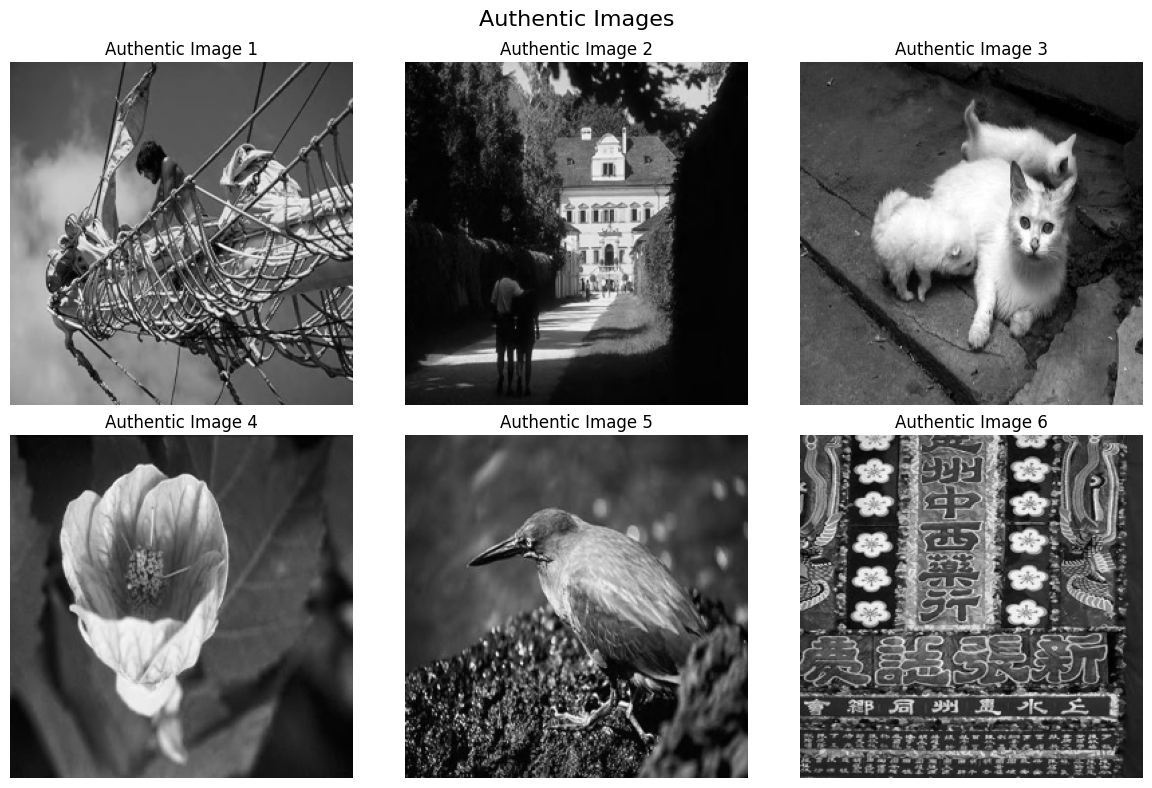

In [7]:
print("Visualizing authentic images:")
visualize_images(authentic_images, "Authentic")

Visualizing tampered images:


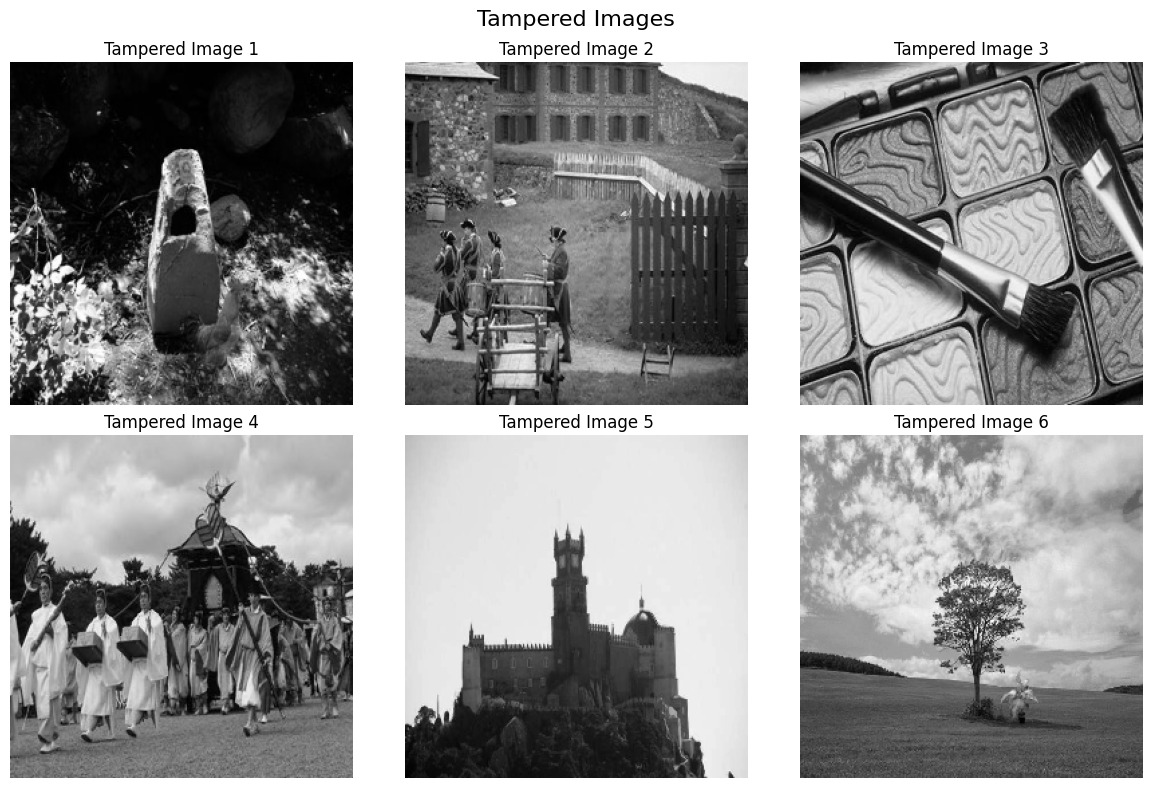

In [8]:
print("Visualizing tampered images:")
visualize_images(tempered_images, "Tampered")

## 2 Apply SVD to Decompose each image and Extract Features to analyze change in Singular Values: K = [50, 100, 200]

### Function to compute energy ratio


In [9]:
def compute_energy_ratio(singular_values, k):
    return np.sum(singular_values[:k]) / np.sum(singular_values)

### Function to compute singular value entropy

In [10]:
def compute_singular_value_entropy(singular_values, k):
    normalized_sv = singular_values[:k] / np.sum(singular_values[:k])
    return entropy(normalized_sv)

### Analyze singular values for top-k and compute statistical metrics


In [11]:
def analyze_singular_values(image_list, k, get_sv_decay=True):
    metrics = []
    sv_decay = []

    for img in image_list:
        # Compute SVD
        U, S, V = np.linalg.svd(img, full_matrices=False)
        if get_sv_decay:
            sv_decay.append(S)  # Store full singular values for decay plot

        # Select top-k singular values
        top_k_sv = S[:k]

        # Compute statistical metrics
        mean = np.mean(top_k_sv)
        variance = np.var(top_k_sv)
        energy_ratio = compute_energy_ratio(S, k)
        sv_entropy = compute_singular_value_entropy(S, k)

        metrics.append({
            'mean': mean,
            'variance': variance,
            'energy_ratio': energy_ratio,
            'sv_entropy': sv_entropy,
        })

    return metrics, sv_decay

### Compare metrics for authentic and tampered images


In [12]:
k_values = [50, 100, 200]

auth_metrics1, auth_sv_decay1 = analyze_singular_values(authentic_images, k_values[0])
temp_metrics1, temp_sv_decay1 = analyze_singular_values(tempered_images, k_values[0])

auth_metrics2, auth_sv_decay2 = analyze_singular_values(authentic_images, k_values[1])
temp_metrics2, temp_sv_decay2 = analyze_singular_values(tempered_images, k_values[1])

auth_metrics3, auth_sv_decay3 = analyze_singular_values(authentic_images, k_values[2])
temp_metrics3, temp_sv_decay3 = analyze_singular_values(tempered_images, k_values[2])

### Compute averages for comparison


#### for k=50

In [13]:
auth_means = np.mean([m['mean'] for m in auth_metrics1])
temp_means = np.mean([m['mean'] for m in temp_metrics1])
print(f"Authentic Images for k={k_values[0]} - Mean: {auth_means:.4f}")
print(f"Tampered Images for k={k_values[0]} - Mean: {temp_means:.4f}")

Authentic Images for k=50 - Mean: 1545.3111
Tampered Images for k=50 - Mean: 1612.8522


#### for k=100

In [14]:
auth_means = np.mean([m['mean'] for m in auth_metrics2])
temp_means = np.mean([m['mean'] for m in temp_metrics2])
print(f"Authentic Images for k={k_values[1]} - Mean: {auth_means:.4f}")
print(f"Tampered Images for k={k_values[1]} - Mean: {temp_means:.4f}")

Authentic Images for k=100 - Mean: 902.4427
Tampered Images for k=100 - Mean: 938.5053


#### for k=200

In [15]:
auth_means = np.mean([m['mean'] for m in auth_metrics3])
temp_means = np.mean([m['mean'] for m in temp_metrics3])
print(f"Authentic Images for k={k_values[2]} - Mean: {auth_means:.4f}")
print(f"Tampered Images for k={k_values[2]} - Mean: {temp_means:.4f}")

Authentic Images for k=200 - Mean: 494.8700
Tampered Images for k=200 - Mean: 514.4185


### Compute varieance for comparison

#### for k=50

In [16]:
auth_variances = np.mean([m['variance'] for m in auth_metrics1])
temp_variances = np.mean([m['variance'] for m in temp_metrics1])
print(f"Authentic Images for k={k_values[0]} - Variance: {auth_variances:.4f}")
print(f"Tampered Images for k={k_values[0]} - Variance: {temp_variances:.4f}")

Authentic Images for k=50 - Variance: 15429384.2373
Tampered Images for k=50 - Variance: 18798666.4752


#### for k=100

In [17]:
auth_variances = np.mean([m['variance'] for m in auth_metrics2])
temp_variances = np.mean([m['variance'] for m in temp_metrics2])
print(f"Authentic Images for k={k_values[1]}- Variance: {auth_variances:.4f}")
print(f"Tampered Images for k={k_values[1]} - Variance: {temp_variances:.4f}")

Authentic Images for k=100- Variance: 8145478.5467
Tampered Images for k=100 - Variance: 9871936.2249


#### for k=200

In [18]:
auth_variances = np.mean([m['variance'] for m in auth_metrics3])
temp_variances = np.mean([m['variance'] for m in temp_metrics3])
print(f"Authentic Images for k={k_values[2]} - Variance: {auth_variances:.4f}")
print(f"Tampered Images for k={k_values[2]} - Variance: {temp_variances:.4f}")

Authentic Images for k=200 - Variance: 4246334.6971
Tampered Images for k=200 - Variance: 5123390.9412


### Compute Energy Ratios for comparison


#### for k=50

In [19]:
auth_energy_ratios = np.mean([m['energy_ratio'] for m in auth_metrics1])
temp_energy_ratios = np.mean([m['energy_ratio'] for m in temp_metrics1])
print(f"Authentic Images for k={k_values[0]}- Energy Ratio: {auth_energy_ratios:.4f}")
print(f"Tampered Images for k={k_values[0]} - Energy Ratio: {temp_energy_ratios:.4f}")

Authentic Images for k=50- Energy Ratio: 0.7858
Tampered Images for k=50 - Energy Ratio: 0.7871


#### for k=100

In [20]:
auth_energy_ratios = np.mean([m['energy_ratio'] for m in auth_metrics2])
temp_energy_ratios = np.mean([m['energy_ratio'] for m in temp_metrics2])
print(f"Authentic Images for k={k_values[1]} - Energy Ratio: {auth_energy_ratios:.4f}")
print(f"Tampered Images for k={k_values[1]} - Energy Ratio: {temp_energy_ratios:.4f}")

Authentic Images for k=100 - Energy Ratio: 0.9114
Tampered Images for k=100 - Energy Ratio: 0.9106


#### for k=200

In [21]:
auth_energy_ratios = np.mean([m['energy_ratio'] for m in auth_metrics3])
temp_energy_ratios = np.mean([m['energy_ratio'] for m in temp_metrics3])
print(f"Authentic Images for k={k_values[2]} - Energy Ratio: {auth_energy_ratios:.4f}")
print(f"Tampered Images for k={k_values[2]} - Energy Ratio: {temp_energy_ratios:.4f}")

Authentic Images for k=200 - Energy Ratio: 0.9937
Tampered Images for k=200 - Energy Ratio: 0.9933


### Compute Singular Vales for comparison


#### for k=50

In [22]:
auth_sv_entropies = np.mean([m['sv_entropy'] for m in auth_metrics1])
temp_sv_entropies = np.mean([m['sv_entropy'] for m in temp_metrics1])
print(f"Authentic Images for k={k_values[0]} - SV Entropy: {auth_sv_entropies:.4f}")
print(f"Tampered Images for k={k_values[0]} - SV Entropy: {temp_sv_entropies:.4f}")

Authentic Images for k=50 - SV Entropy: 2.9405
Tampered Images for k=50 - SV Entropy: 2.8683


#### for k=100

In [23]:
auth_sv_entropies = np.mean([m['sv_entropy'] for m in auth_metrics2])
temp_sv_entropies = np.mean([m['sv_entropy'] for m in temp_metrics2])
print(f"Authentic Images for k={k_values[1]} - SV Entropy: {auth_sv_entropies:.4f}")
print(f"Tampered Images for k={k_values[1]} - SV Entropy: {temp_sv_entropies:.4f}")

Authentic Images for k=100 - SV Entropy: 3.4578
Tampered Images for k=100 - SV Entropy: 3.3903


#### for k=200

In [24]:
auth_sv_entropies = np.mean([m['sv_entropy'] for m in auth_metrics3])
temp_sv_entropies = np.mean([m['sv_entropy'] for m in temp_metrics3])
print(f"Authentic Images for k={k_values[2]} - SV Entropy: {auth_sv_entropies:.4f}")
print(f"Tampered Images for k={k_values[2]} - SV Entropy: {temp_sv_entropies:.4f}")

Authentic Images for k=200 - SV Entropy: 3.8093
Tampered Images for k=200 - SV Entropy: 3.7504


### Function to plot Singular Value Decay Curve

In [25]:
def plot_singular_value_decay(auth_sv, temp_sv, k):
    plt.figure(figsize=(10, 6))
    
    # Plot average decay for authentic images
    auth_avg_decay = np.mean(auth_sv, axis=0)
    temp_avg_decay = np.mean(temp_sv, axis=0)

    plt.plot(auth_avg_decay[:k], label="Authentic", marker="o")
    plt.plot(temp_avg_decay[:k], label="Tampered", marker="x")

    plt.title("Singular Value Decay Curve")
    plt.xlabel(f"Top-{k} Singular Values")
    plt.ylabel("Singular Value Magnitude")
    plt.legend()
    plt.grid(True)
    plt.show()

### Visualize decay curves

#### for k=50

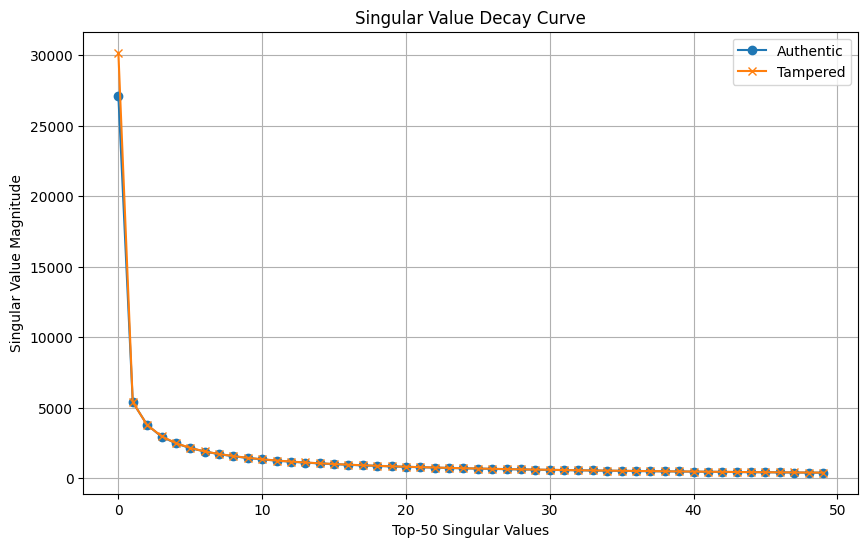

In [26]:
plot_singular_value_decay(auth_sv_decay1, temp_sv_decay1, k_values[0])

#### for k=100

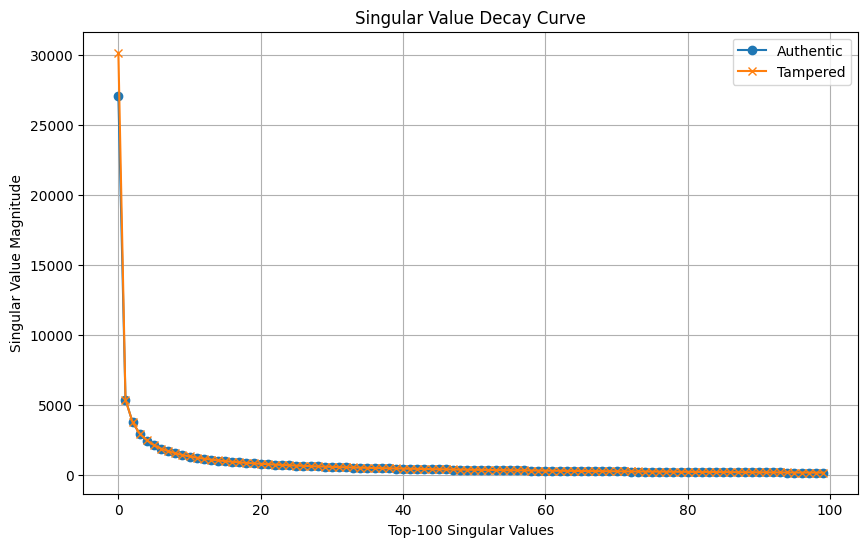

In [27]:
plot_singular_value_decay(auth_sv_decay2, temp_sv_decay2, k_values[1])

#### for k=200

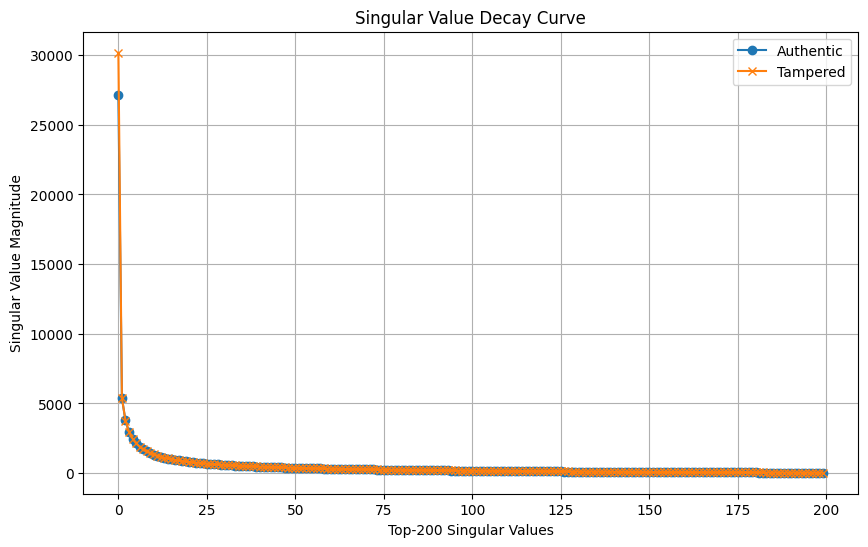

In [28]:
plot_singular_value_decay(auth_sv_decay3, temp_sv_decay3, k_values[2])

## 3 Highlight tampered regions by overlaying heatmaps.

### Function to divide the image into blocks


In [29]:
def divide_into_blocks(image, block_size=(16, 16)):
    """
    Divides the input image into non-overlapping blocks of the given size.
    """
    h, w = image.shape
    bh, bw = block_size
    return view_as_blocks(image, block_size).reshape(-1, bh, bw)

### Function to compute SVD metrics for each block

In [30]:
def compute_block_metrics(blocks, K):
    """
    Computes singular value metrics (mean, variance, energy ratio, entropy) for each block.
    """

    for block in blocks:
        metrics, _ = analyze_singular_values(blocks, K, get_sv_decay=False)
    
    return metrics

### Function to detect anomalies in blocks


In [31]:
def detect_anomalies(metrics, threshold_factor=2.0):
    """
    Detect blocks with significant deviations from global statistics.
    """
    global_means = np.mean([m['mean'] for m in metrics])
    global_variances = np.mean([m['variance'] for m in metrics])
    global_energy_ratios = np.mean([m['energy_ratio'] for m in metrics])
    global_entropies = np.mean([m['sv_entropy'] for m in metrics])

    anomalies = []
    for idx, m in enumerate(metrics):
        if (
            abs(m['variance'] - global_variances) > threshold_factor * global_variances or
            abs(m['energy_ratio'] - global_energy_ratios) > threshold_factor * global_energy_ratios
        ):
            anomalies.append(idx)
    return anomalies

### Function to visualize anomalies with heatmap


In [32]:
def visualize_heatmap(image, block_size, anomalies, blocks_per_row):
    """
    Overlays a heatmap on the original image to highlight tampered regions.
    """
    heatmap = np.zeros_like(image, dtype=np.float32)
    h, w = image.shape
    bh, bw = block_size

    for idx in anomalies:
        row = idx // blocks_per_row
        col = idx % blocks_per_row
        heatmap[row * bh:(row + 1) * bh, col * bw:(col + 1) * bw] = 1.0

    plt.figure(figsize=(10, 6))
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Tampered Region Heatmap")
    plt.axis("off")
    plt.show()

#### Plot tempered images with k=50

Processing Images...
Visualizing Heatmap for Image 4094


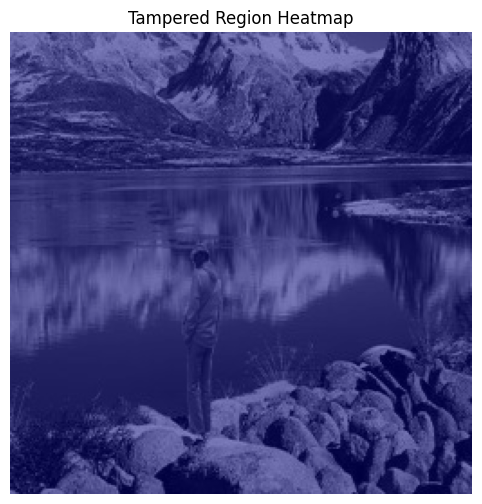

Visualizing Heatmap for Image 895


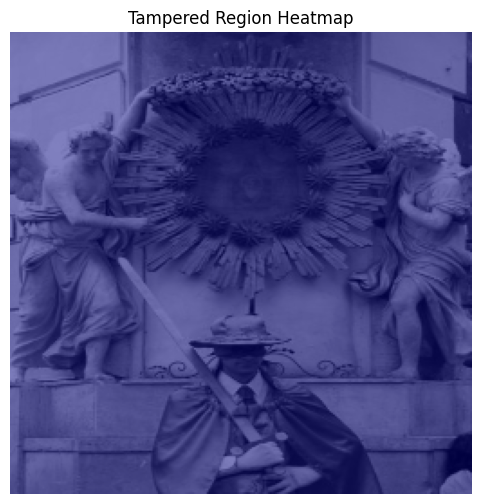

Visualizing Heatmap for Image 2759


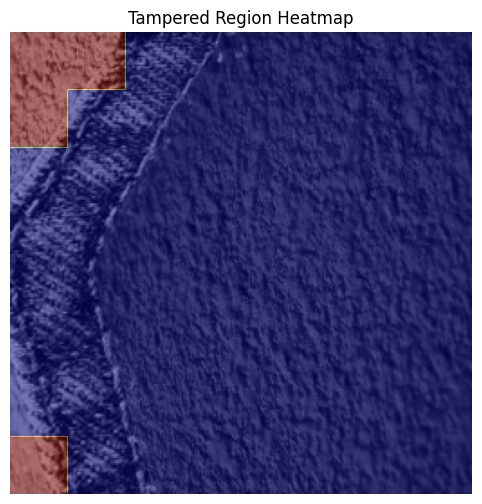

Visualizing Heatmap for Image 1975


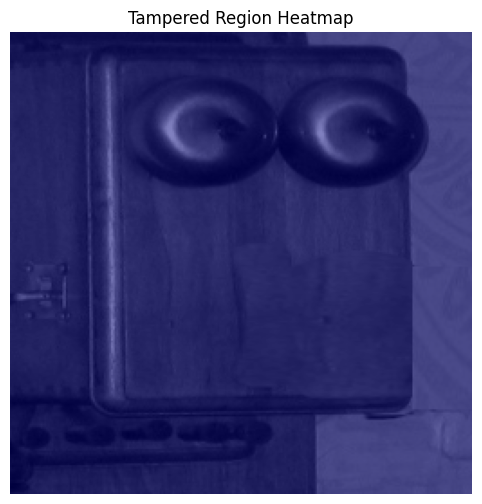

Visualizing Heatmap for Image 3687


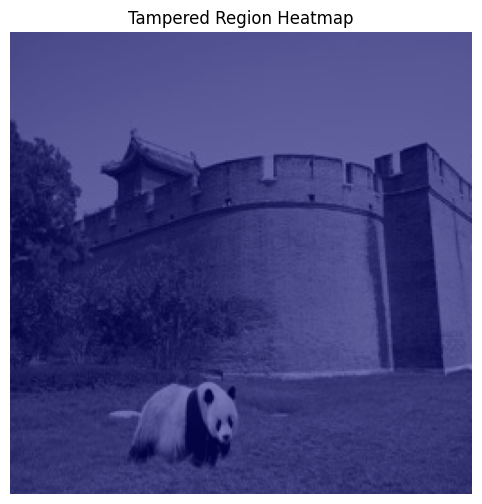

Visualizing Heatmap for Image 1912


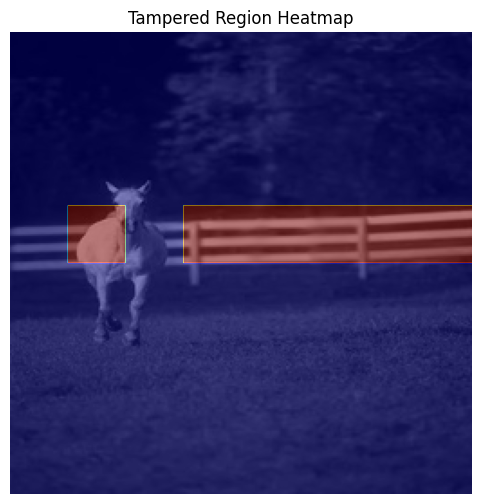

In [33]:
block_size = (32, 32)  # Block size for dividing images
k = k_values[0]  # Top-k singular values


num_images_to_plot = 6
print("Processing Images...")
# Process authentic and tempered images
for idx, image_set in enumerate([authentic_images, tempered_images]):
    set_name = "Authentic" if idx == 0 else "Tempered"
    

    # Randomly select 6 images from the set
    selected_indices = random.sample(range(len(image_set)), num_images_to_plot)

    # Get the selected image
    for i in selected_indices:
        image = image_set[i]  

        # Convert to grayscale if not already
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Divide the image into blocks
        image_blocks = divide_into_blocks(image, block_size)

        # Compute metrics for each block
        block_metrics = compute_block_metrics(image_blocks, k)

        # Detect anomalies in metrics
        anomalies = detect_anomalies(block_metrics)

        # Visualize tampered regions for tempered images
        if set_name == "Tempered":
            print(f"Visualizing Heatmap for Image {i + 1}")
            blocks_per_row = image.shape[1] // block_size[1]
            visualize_heatmap(image, block_size, anomalies, blocks_per_row)

#### Plot Images with k=100

Processing Images...
Visualizing Heatmap for Image 1044


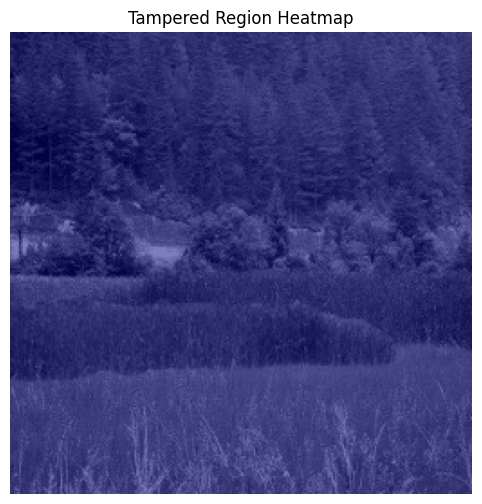

Visualizing Heatmap for Image 4772


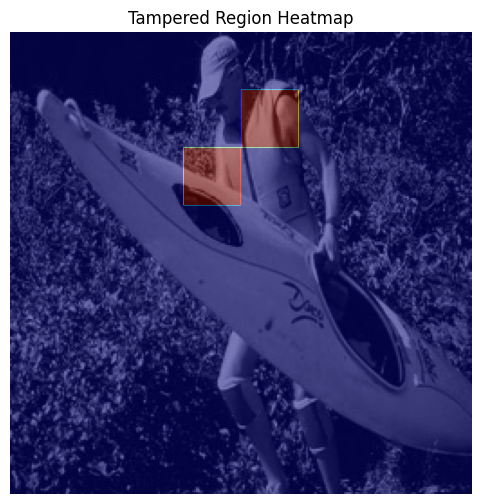

Visualizing Heatmap for Image 3835


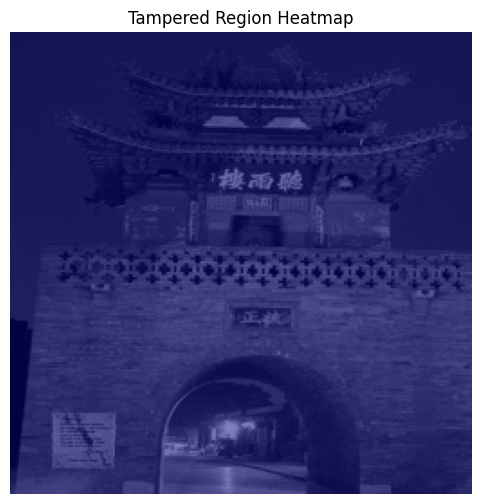

Visualizing Heatmap for Image 4397


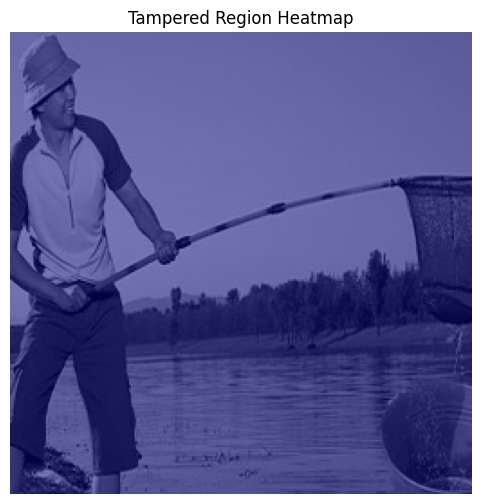

Visualizing Heatmap for Image 2192


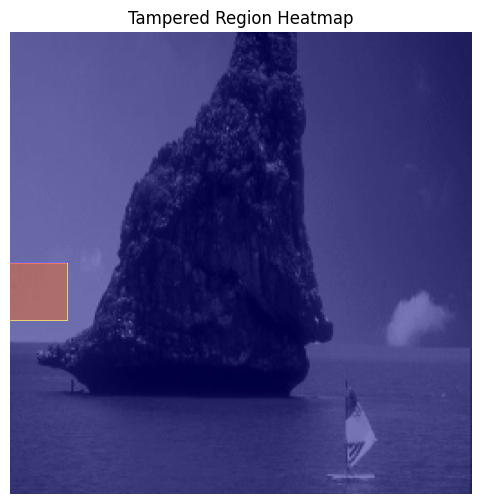

Visualizing Heatmap for Image 2882


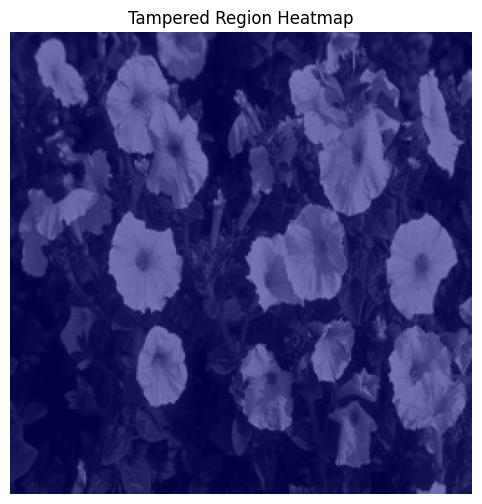

In [34]:
block_size = (32, 32)  # Block size for dividing images
k = k_values[1]  # Top-k singular values


num_images_to_plot = 6
print("Processing Images...")
# Process authentic and tempered images
for idx, image_set in enumerate([authentic_images, tempered_images]):
    set_name = "Authentic" if idx == 0 else "Tempered"
    

    # Randomly select 6 images from the set
    selected_indices = random.sample(range(len(image_set)), num_images_to_plot)

    # Get the selected image
    for i in selected_indices:
        image = image_set[i]  

        # Convert to grayscale if not already
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Divide the image into blocks
        image_blocks = divide_into_blocks(image, block_size)

        # Compute metrics for each block
        block_metrics = compute_block_metrics(image_blocks, k)

        # Detect anomalies in metrics
        anomalies = detect_anomalies(block_metrics)

        # Visualize tampered regions for tempered images
        if set_name == "Tempered":
            print(f"Visualizing Heatmap for Image {i + 1}")
            blocks_per_row = image.shape[1] // block_size[1]
            visualize_heatmap(image, block_size, anomalies, blocks_per_row)

#### Plot tempered Images with k = 200

Processing Images...
Visualizing Heatmap for Image 1963


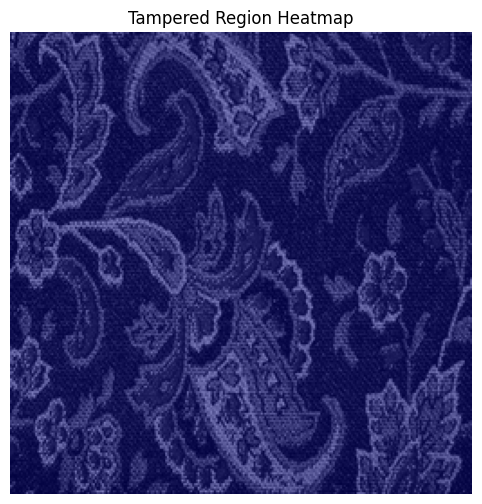

Visualizing Heatmap for Image 3762


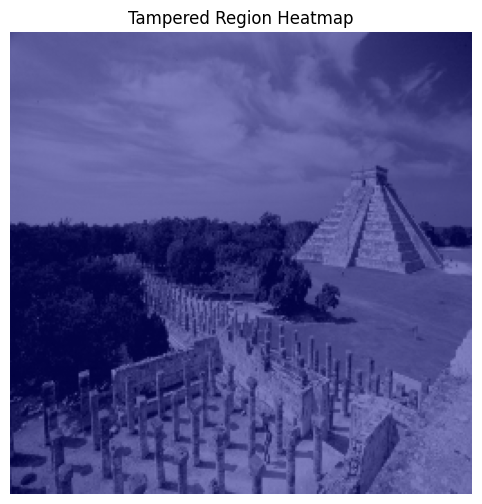

Visualizing Heatmap for Image 4304


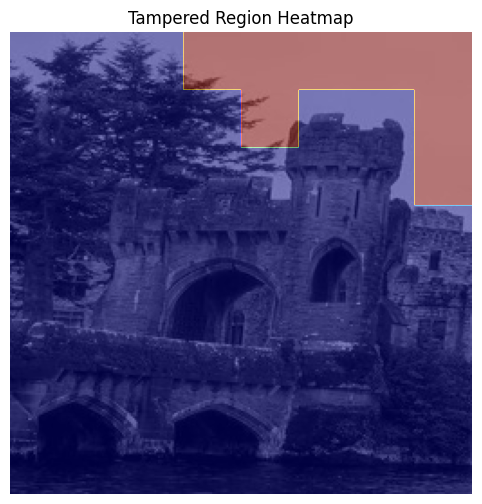

Visualizing Heatmap for Image 1051


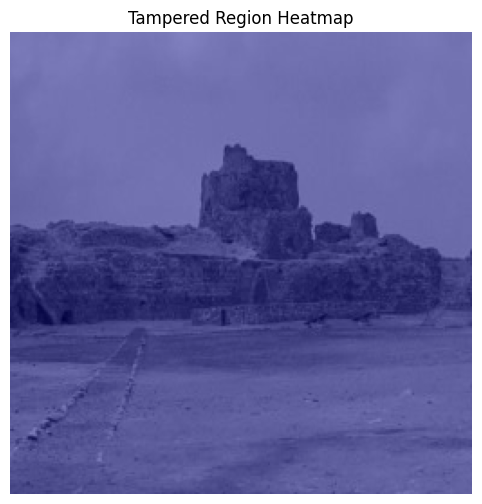

Visualizing Heatmap for Image 2573


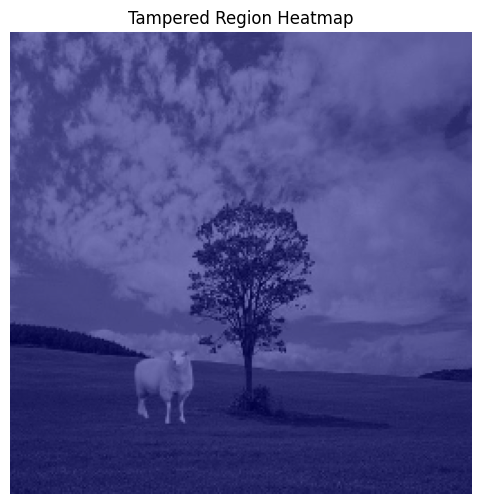

Visualizing Heatmap for Image 921


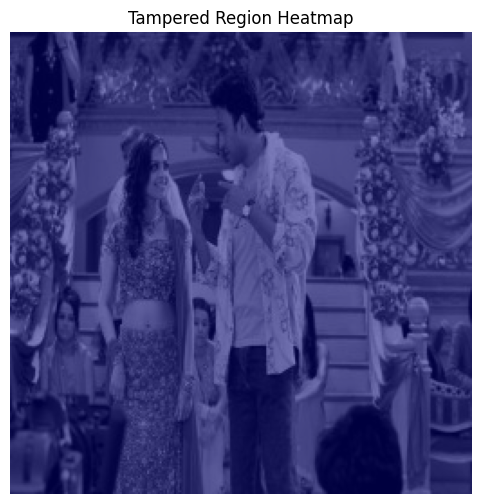

In [35]:
block_size = (32, 32)  # Block size for dividing images
k = k_values[2]  # Top-k singular values


num_images_to_plot = 6
print("Processing Images...")
# Process authentic and tempered images
for idx, image_set in enumerate([authentic_images, tempered_images]):
    set_name = "Authentic" if idx == 0 else "Tempered"
    

    # Randomly select 6 images from the set
    selected_indices = random.sample(range(len(image_set)), num_images_to_plot)

    # Get the selected image
    for i in selected_indices:
        image = image_set[i]  

        # Convert to grayscale if not already
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Divide the image into blocks
        image_blocks = divide_into_blocks(image, block_size)

        # Compute metrics for each block
        block_metrics = compute_block_metrics(image_blocks, k)

        # Detect anomalies in metrics
        anomalies = detect_anomalies(block_metrics)

        # Visualize tampered regions for tempered images
        if set_name == "Tempered":
            print(f"Visualizing Heatmap for Image {i + 1}")
            blocks_per_row = image.shape[1] // block_size[1]
            visualize_heatmap(image, block_size, anomalies, blocks_per_row)

## Let's classify these images (Authentic or Tempered)


### Check if GPU is available for training

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using {device} for training...")

Using cuda for training...


### CustomDataset class to read data for modeling

In [37]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, num_samples=NUM_SAMPLES, size=(256, 256), transform=None):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            num_samples (int): Number of samples to load (default is 500).
            size (tuple): Target size to resize images (default is (256, 256)).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_folder = image_folder
        self.num_samples = num_samples
        self.size = size
        self.transform = transform
        
        # Get all image paths in the folder
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]
        
        # Ensure the number of samples does not exceed available images
        self.image_paths = self.image_paths[:self.num_samples]
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Load the image using OpenCV
        img = cv2.imread(img_path)
        
        # Check if the image is loaded correctly
        if img is None:
            raise Exception(f"Image at {img_path} could not be loaded.")
        
        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize image
        img = cv2.resize(img, self.size)
        
        # Convert the image from ndarray to PIL Image to apply transforms
        img = Image.fromarray(img)  
        
        # Apply the transform if provided
        if self.transform:
            img = self.transform(img)
        
        # Label: 0 for authentic and 1 for tampered (Label assignment based on folder name)
        label = 0 if 'Au' in img_path else 1  

        return img, label

### Transformations for data augmentation and normalization


In [38]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

# Load the datasets
authentic_dataset = CustomDataset(authentic_path, num_samples=NUM_SAMPLES, size=(256, 256), transform=transform)
tempered_dataset = CustomDataset(tempered_path, num_samples=NUM_SAMPLES, size=(256, 256), transform=transform)


# Combine both datasets into one
combined_dataset = ConcatDataset([authentic_dataset, tempered_dataset])

# Create DataLoader for batching and shuffling the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

for images, labels in combined_loader:
    print(images.shape)  
    print(labels.shape)  
    break


torch.Size([32, 1, 256, 256])
torch.Size([32])


### Split the dataset into training and testing (80% train, 20% test)


In [39]:
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = random_split(combined_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for images, labels in train_loader:
    print(images.shape) 
    print(labels.shape)  
    break  

torch.Size([32, 1, 256, 256])
torch.Size([32])


### Define a custom CNN model for classification


In [40]:
class FCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FCNN, self).__init__()
        
        # Define the layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  
        self.fc2 = nn.Linear(512, num_classes)  
        
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.8)  
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        
        x = x.view(-1, 128 * 32 * 32)  
        x = F.relu(self.fc1(x))  
        x = self.dropout(x)  
        x = self.fc2(x)  
        
        return x

### Initialize the model and parameters


In [41]:
# Initialize the model
model = FCNN(num_classes=2)
# Move the model to GPU if available
model = model.to(device)  

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs and batch size
num_epochs = 10
batch_size = 32

### Function for model training


In [42]:
def train_model():
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()  
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

In [43]:
train_model()

Epoch [1/10], Loss: 0.6712, Accuracy: 69.99%
Epoch [2/10], Loss: 0.5931, Accuracy: 70.98%
Epoch [3/10], Loss: 0.5881, Accuracy: 70.98%
Epoch [4/10], Loss: 0.5819, Accuracy: 71.01%
Epoch [5/10], Loss: 0.5537, Accuracy: 72.84%
Epoch [6/10], Loss: 0.5081, Accuracy: 75.63%
Epoch [7/10], Loss: 0.4676, Accuracy: 78.69%
Epoch [8/10], Loss: 0.4262, Accuracy: 81.07%
Epoch [9/10], Loss: 0.4001, Accuracy: 83.33%
Epoch [10/10], Loss: 0.3673, Accuracy: 84.59%


### Function to Evaluate the model


In [44]:
# Updated Evaluate function
def evaluate_model():
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and true labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    print(f'Test Accuracy: {100 * correct/total:.2f}%')

    # Return predictions and labels for external analysis
    return all_predictions, all_labels

In [45]:
# Call the evaluation function
predictions, labels = evaluate_model()

Test Accuracy: 75.65%


### Classification Report

In [46]:
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=['Authentic', 'Tempered']))


Classification Report:
              precision    recall  f1-score   support

   Authentic       0.78      0.92      0.84       989
    Tempered       0.66      0.38      0.49       424

    accuracy                           0.76      1413
   macro avg       0.72      0.65      0.66      1413
weighted avg       0.74      0.76      0.73      1413



### F1-Score

In [47]:
f1 = f1_score(labels, predictions, average='weighted')
print(f"F1-Score: {f1:.2f}")

F1-Score: 0.73


### Plot Confusion Matrix

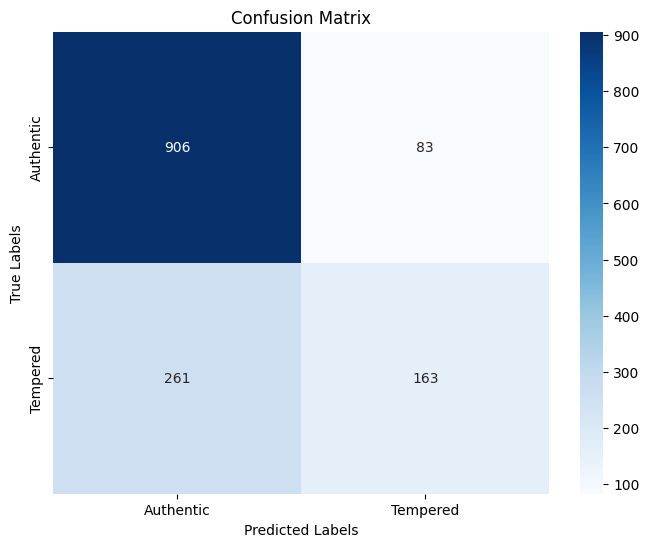

In [48]:
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Authentic', 'Tempered'], yticklabels=['Authentic', 'Tempered'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Visualize the prediction made by model 

In [49]:
def visualize_predictions():
    model.eval()  
    dataiter = iter(test_loader)  
    images, labels = next(dataiter)  
    images, labels = images.to(device), labels.to(device)  

    # Forward pass through the model
    outputs = model(images)
    # Get the predicted class labels
    _, preds = torch.max(outputs, 1)  

    # Convert the image tensor back to numpy for plotting
    # Move images to CPU for processing
    images = images.cpu().numpy()  
    images = images.transpose(0, 2, 3, 1)  
    images = images.squeeze()  

    images = images / 2 + 0.5  

    # Plot the images and their predictions
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))  
    for i in range(6):
        axes[i].imshow(images[i], cmap='gray')  
        axes[i].set_title(f'Pred: {["Authentic", "Tampered"][preds[i]]}\nTrue: {["Authentic", "Tampered"][labels[i]]}')
        axes[i].axis('off')  

    plt.show()

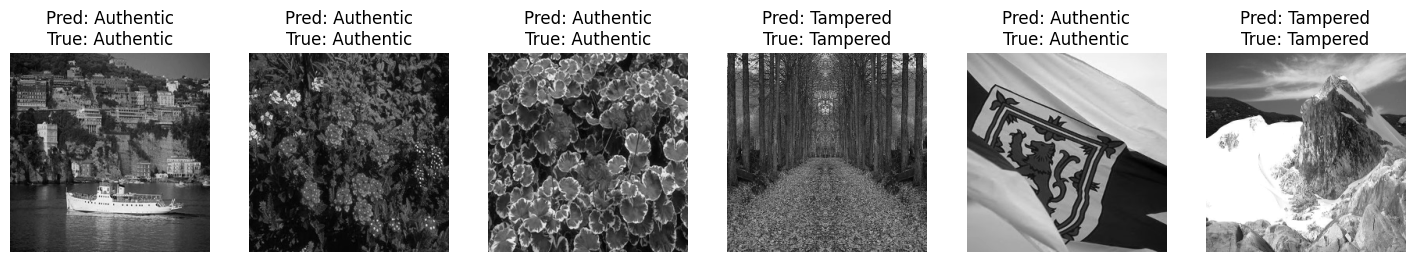

In [50]:
visualize_predictions()